In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3
import keras
from tensorflow.compat.v1.keras import backend as K
from tensorflow.keras.initializers import RandomNormal, Constant
from mixup_generator import MixupImageDataGenerator

In [2]:
train_img=pd.read_csv('train_img.csv')
valid_img=pd.read_csv('valid_img.csv')
train_img.drop(columns=['Unnamed: 0'],inplace=True)
valid_img.drop(columns=['Unnamed: 0'],inplace=True)

In [3]:
IMAGE_SIZE = 220
BATCH_SIZE = 12

In [4]:
img_gen = ImageDataGenerator(rescale = 1.0/255.0, horizontal_flip = True, vertical_flip   = True,
                               fill_mode = 'nearest', rotation_range = 10, width_shift_range = 0.2,
                               height_shift_range= 0.2, shear_range= 0.2, brightness_range= (0.5,1.2),
                               zoom_range = 0.2)
train = img_gen.flow_from_dataframe(train_img, directory = 'train',x_col = 'filename', y_col = 'label', 
                                  target_size =(IMAGE_SIZE, IMAGE_SIZE), class_mode = 'categorical',
                                  batch_size = BATCH_SIZE, color_mode = 'rgb', shuffle = True)
val = img_gen.flow_from_dataframe(valid_img, directory = 'train',x_col = 'filename', y_col = 'label', 
                                  target_size =(IMAGE_SIZE, IMAGE_SIZE), class_mode = 'categorical',
                                  batch_size = BATCH_SIZE, color_mode = 'rgb', shuffle = True)

Found 4524 validated image filenames belonging to 5 classes.
Found 566 validated image filenames belonging to 5 classes.


In [5]:
print("GPU number: ", len(tf.config.experimental.list_physical_devices('GPU')))

GPU number:  1


In [6]:
def create_model():
    
    model = Sequential()
    model.add(EfficientNetB3(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False, 
                             weights='imagenet', drop_connect_rate=0.5))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation = 'softmax'))
    
    return model

leaf_model = create_model()
leaf_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 7, 7, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               393472    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 11,178,292
Trainable params: 11,090,989
Non-trainable params: 87,303
_______________________________________

In [7]:
EPOCHS = 40
STEP_TRAIN = train.n // train.batch_size
STEP_TEST = val.n // val.batch_size

In [8]:
def model_fit():
    model = create_model()
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,label_smoothing=1e-3,name='categorical_crossentropy')
    model.compile(optimizer = Adam(learning_rate = 1e-3), loss = loss, metrics = ['categorical_accuracy'])
    es = EarlyStopping(monitor='val_loss', mode='min', patience=5,restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint("efficientNetDrop_best.h5",save_best_only=True,monitor='val_loss',mode='min')
    lr = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=2,min_lr=1e-10,mode='min',verbose=1)
    history = model.fit(train,validation_data=val,epochs=EPOCHS,batch_size=BATCH_SIZE,
                             steps_per_epoch=STEP_TRAIN, validation_steps=STEP_TEST,
                              callbacks=[checkpoint, lr])
    model.save('efficientNetDrop'+'.h5')  
    return history

In [9]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
K.set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5



In [10]:
with tf.device('/GPU:0'):
    results = model_fit()
print('Train Categorical Accuracy: ', max(results.history['categorical_accuracy']))
print('Test Categorical Accuracy: ', max(results.history['val_categorical_accuracy']))

Epoch 1/40
377/377 [==============================] - 211s 499ms/step - loss: 1.2431 - categorical_accuracy: 0.5295 - val_loss: 2.2676 - val_categorical_accuracy: 0.0408
Epoch 2/40
377/377 [==============================] - 190s 504ms/step - loss: 0.9511 - categorical_accuracy: 0.6612 - val_loss: 2.1895 - val_categorical_accuracy: 0.0408
Epoch 3/40
377/377 [==============================] - 193s 511ms/step - loss: 0.8172 - categorical_accuracy: 0.7257 - val_loss: 3.1220 - val_categorical_accuracy: 0.1489
Epoch 4/40
377/377 [==============================] - 194s 514ms/step - loss: 0.7666 - categorical_accuracy: 0.7405 - val_loss: 2.2032 - val_categorical_accuracy: 0.2234

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/40
377/377 [==============================] - 195s 517ms/step - loss: 0.6799 - categorical_accuracy: 0.7884 - val_loss: 2.6596 - val_categorical_accuracy: 0.1436
Epoch 6/40
377/377 [==============================] - 193s 513ms/ste

In [11]:
def train_test_plot(acc, test_acc, loss, test_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,5))
    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(test_acc) + 1), test_acc)
    ax1.set_title('Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(test_loss) + 1), test_loss)
    ax2.set_title('Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()

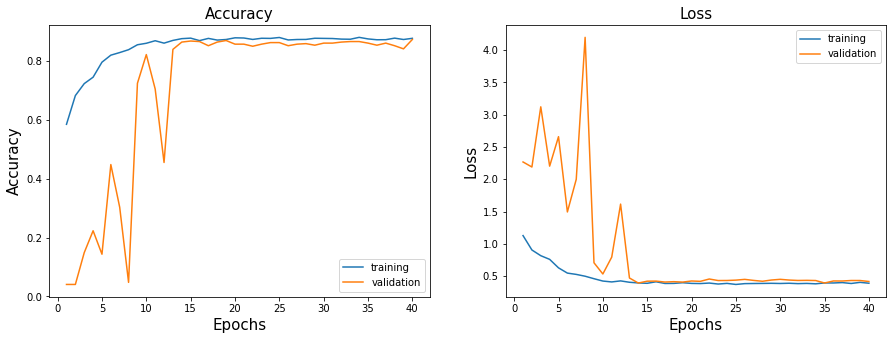

In [12]:
train_test_plot(
    results.history['categorical_accuracy'],
    results.history['val_categorical_accuracy'],
    results.history['loss'],
    results.history['val_loss']
)